# Session 7. 지도학습2
## Decision Tree / Support Vector Machine / Random Foreset / XGBoost

#### 작성자: 5기 공채린
#### 퀘스트 기한: 2019. 10. 13 (일) 23:59

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale

import os

In [2]:
df = pd.read_csv('AB_NYC_2019.csv', encoding='utf-8')
df.head(50)

id                                               name  host_id  \
0    2539                 Clean & quiet apt home by the park     2787   
1    2595                              Skylit Midtown Castle     2845   
2    3647                THE VILLAGE OF HARLEM....NEW YORK !     4632   
3    3831                    Cozy Entire Floor of Brownstone     4869   
4    5022   Entire Apt: Spacious Studio/Loft by central park     7192   
5    5099          Large Cozy 1 BR Apartment In Midtown East     7322   
6    5121                                    BlissArtsSpace!     7356   
7    5178                   Large Furnished Room Near B'way      8967   
8    5203                 Cozy Clean Guest Room - Family Apt     7490   
9    5238                 Cute & Cozy Lower East Side 1 bdrm     7549   
10   5295                   Beautiful 1br on Upper West Side     7702   
11   5441                    Central Manhattan/near Broadway     7989   
12   5803     Lovely Room 1, Garden, Best Area, Legal rental     9744   
13   6021   Wonderful Guest Bedroom in Manhattan for SINGLES    11528   
14   6090                      West Village Nest - Superhost    11975   
15   6848                   Only 2 stops to Manhattan studio    15991   
16   7097                  Perfect for Your Parents + Garden    17571   
17   7322                                    Chelsea Perfect    18946   
18   7726    Hip Historic Brownstone Apartment with Backyard    20950   
19   7750                  Huge 2 BR Upper East  Cental Park    17985   
20   7801                   Sweet and Spacious Brooklyn Loft    21207   
21   8024                     CBG CtyBGd HelpsHaiti rm#1:1-4    22486   
22   8025                           CBG Helps Haiti Room#2.5    22486   
23   8110                              CBG Helps Haiti Rm #2    22486   
24   8490             MAISON DES SIRENES1,bohemian apartment    25183   
25   8505                 Sunny Bedroom Across Prospect Park    25326   
26   8700  Magnifique Suite au N de Manhattan - vue Cloitres    26394   
27   9357                               Midtown Pied-a-terre    30193   
28   9518       SPACIOUS, LOVELY FURNISHED MANHATTAN BEDROOM    31374   
29   9657                   Modern 1 BR / NYC / EAST VILLAGE    21904   
30   9668                              front room/double bed    32294   
31   9704                Spacious 1 bedroom in luxe building    32045   
32   9782                  Loft in Williamsburg Area w/ Roof    32169   
33   9783                                back room/bunk beds    32294   
34  10452                              Large B&B Style rooms    35935   
35  10962    Lovely room 2 & garden; Best area, Legal rental     9744   
36  11452                        Clean and Quiet in Brooklyn     7355   
37  11708                          Cute apt in artist's home    44145   
38  11943                          Country space in the city    45445   
39  12048                LowerEastSide apt share shortterm 1     7549   
40  12192                                ENJOY Downtown NYC!    46978   
41  12299                Beautiful Sunny Park Slope Brooklyn    47610   
42  12303                  1bdr w private bath. in lofty apt    47618   
43  12318                                  West Side Retreat    16800   
44  12343                                 BEST BET IN HARLEM    47727   
45  12627  Entire apartment in central Brooklyn neighborh...    49670   
46  12937  1 Stop fr. Manhattan! Private Suite,Landmark B...    50124   
47  12940                 Charming Brownstone 3 - Near PRATT    50148   
48  13050                          bright and stylish duplex    50846   
49  13394                            Fort Greene brownstone     52335   

           host_name neighbourhood_group              neighbourhood  latitude  \
0               John            Brooklyn                 Kensington  40.64749   
1           Jennifer           Manhattan                    Midtown  40.75362   
2          Elisabeth           Manhattan

뉴욕의 에어비엔비 데이터셋을 활용하여 방 타입, 숙박 가격, 최소숙박일수, 최근리뷰, 월 리뷰갯수 등으로부터 숙소의 위치를 알아내는 모델

편의상 맨하튼, 브루클린의 숙소들로 범위를 좁혔습니다

In [3]:
our_set = df[df['neighbourhood_group'].isin(['Brooklyn', 'Manhattan'])] ## neighbourhood 컬럼에 brooklyn과 manhattan이 있는 행들만 살림
our_set.shape, df.shape ## df의 행은 48000개였으나, out_set은 41700개로 낮아진 것을 확인할 수 있습니다.

((41765, 16), (48895, 16))

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

### 전체적인 가격대 분포 살펴보기

Text(0, 0.5, 'Ratio')

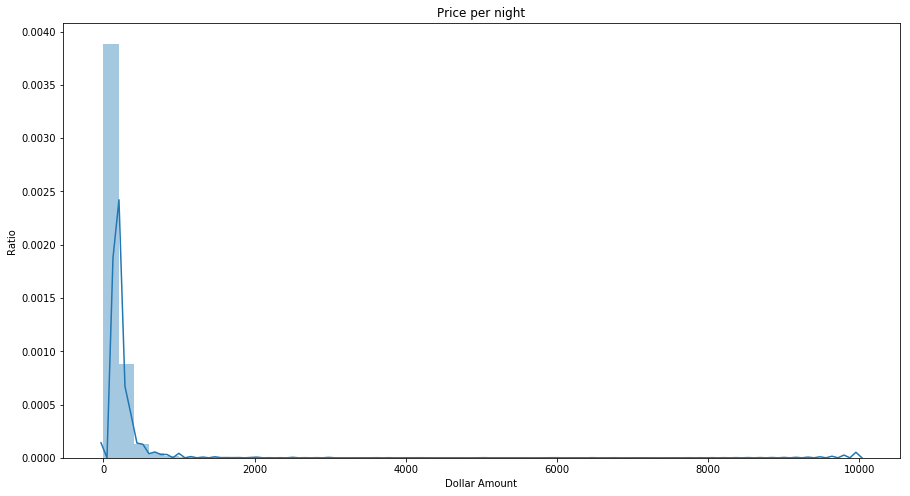

In [5]:
plt.figure(figsize=(15,8))
sns.distplot(our_set['price']) ## distplot은 히스토그램과 kdeplot을 함께 그려줌, price가 어떤 분포로 존재하고 있는지를 알려고 함.
plt.title("Price per night")
plt.xlabel('Dollar Amount')
plt.ylabel('Ratio')

Text(0, 0.5, 'Ratio')

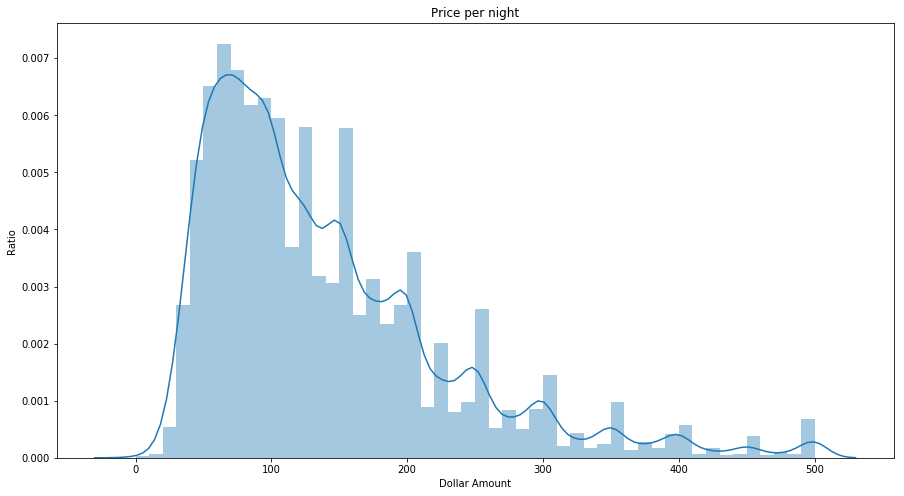

In [6]:
## 왼쪽에만 몰려 있어서, 잘 안보여서 500 이하인 것만 자세히 봤음
plt.figure(figsize=(15,8))
sns.distplot(our_set[our_set['price']<=500]['price'])
plt.title("Price per night")
plt.xlabel('Dollar Amount')
plt.ylabel('Ratio')

### 방 타입에는 어떤 것들이 있나...

In [7]:
set(our_set['room_type'])

{'Entire home/apt', 'Private room', 'Shared room'}

In [8]:
import random

random_seed = random.randint(0,1000)

### 자연어를 기계가 알아들을 수 있게 수치로 변환

In [9]:
our_set = our_set.replace('Brooklyn', 0).replace('Manhattan', 1)

In [10]:
our_set

id                                               name    host_id  \
0          2539                 Clean & quiet apt home by the park       2787   
1          2595                              Skylit Midtown Castle       2845   
2          3647                THE VILLAGE OF HARLEM....NEW YORK !       4632   
3          3831                    Cozy Entire Floor of Brownstone       4869   
4          5022   Entire Apt: Spacious Studio/Loft by central park       7192   
5          5099          Large Cozy 1 BR Apartment In Midtown East       7322   
6          5121                                    BlissArtsSpace!       7356   
7          5178                   Large Furnished Room Near B'way        8967   
8          5203                 Cozy Clean Guest Room - Family Apt       7490   
9          5238                 Cute & Cozy Lower East Side 1 bdrm       7549   
10         5295                   Beautiful 1br on Upper West Side       7702   
11         5441                    Central Manhattan/near Broadway       7989   
12         5803     Lovely Room 1, Garden, Best Area, Legal rental       9744   
13         6021   Wonderful Guest Bedroom in Manhattan for SINGLES      11528   
14         6090                      West Village Nest - Superhost      11975   
15         6848                   Only 2 stops to Manhattan studio      15991   
16         7097                  Perfect for Your Parents + Garden      17571   
17         7322                                    Chelsea Perfect      18946   
18         7726    Hip Historic Brownstone Apartment with Backyard      20950   
19         7750                  Huge 2 BR Upper East  Cental Park      17985   
20         7801                   Sweet and Spacious Brooklyn Loft      21207   
21         8024                     CBG CtyBGd HelpsHaiti rm#1:1-4      22486   
22         8025                           CBG Helps Haiti Room#2.5      22486   
23         8110                              CBG Helps Haiti Rm #2      22486   
24         8490             MAISON DES SIRENES1,bohemian apartment      25183   
25         8505                 Sunny Bedroom Across Prospect Park      25326   
26         8700  Magnifique Suite au N de Manhattan - vue Cloitres      26394   
27         9357                               Midtown Pied-a-terre      30193   
28         9518       SPACIOUS, LOVELY FURNISHED MANHATTAN BEDROOM      31374   
29         9657                   Modern 1 BR / NYC / EAST VILLAGE      21904   
...         ...                                                ...        ...   
48861  36468409    One bedroom Manhattan Upper East Side Apartment   57502664   
48862  36468880          Private room in a nice Brooklyn apartment  274195458   
48864  36471896    Private Bedroom & PRIVATE BATHROOM in Manhattan   23548340   
48865  36472171                      1 bedroom in sunlit apartment   99144947   
48867  36473044    The place you were dreaming for.(only for guys)  261338177   
48868  36473253                       Heaven for you(only for guy)  261338177   
48869  36474023                        Cozy, Sunny Brooklyn Escape    1550580   
48870  36474911      Cozy, clean Williamsburg 1- bedroom apartment    1273444   
48871  36475746      A LARGE ROOM - 1 MONTH MINIMUM - WASHER&DRYER  144008701   
48872  36476675                                      Nycity-MyHome    8636072   
48873  36477307                                  Brooklyn paradise  241945355   
48874  36477588                   Short Term Rental in East Harlem  214535893   
48875  36478343                              Welcome all as family  274273284   
48876  36478357    Cozy, Air-Conditioned Private Bedroom in Harlem  177932088   
48877  36479230             Studio sized room with beautiful light   65767720   
48879  36480292  Gorgeous 1.5 Bdr with a private yard- Williams...     540335   
48880  36481315  The Raccoon Artist Studio in Williamsburg New ...  208514239   
48881  36481615                   Peaceful s

### 룸 타입 역시 자연어로 되어있으므로, "원핫인코딩"을 통해 수치로 변환

In [11]:
#a=our_set['last_review']
#a= a.reshape(-1,1)

AttributeError: 'Series' object has no attribute 'reshape'

In [12]:
#scaler = preprocessing.MinMaxScaler()
#a = scaler.fit_transform(a)

ValueError: could not convert string to float: '2018-10-19'

In [13]:
our_set['last_review'] = our_set['last_review'].str.replace('-', '')
our_set['last_review']

0        20181019
1        20190521
2             NaN
3        20190705
4        20181119
5        20190622
6        20171005
7        20190624
8        20170721
9        20190609
10       20190622
11       20190623
12       20190624
13       20190705
14       20181031
15       20190629
16       20190628
17       20190701
18       20190622
19            NaN
20       20111228
21       20190701
22       20190101
23       20190702
24       20190619
25       20190623
26            NaN
27       20170813
28       20190615
29       20190419
           ...   
48861         NaN
48862         NaN
48864         NaN
48865         NaN
48867         NaN
48868         NaN
48869         NaN
48870         NaN
48871         NaN
48872         NaN
48873         NaN
48874         NaN
48875         NaN
48876         NaN
48877         NaN
48879         NaN
48880         NaN
48881         NaN
48882         NaN
48883         NaN
48884         NaN
48885         NaN
48886         NaN
48887         NaN
48888     

In [14]:
x = pd.get_dummies(our_set['room_type'])
## room type은 string 형태이므로 get_dummies해서 더미변수화해줌
core_cols = our_set[['neighbourhood_group', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']]
## id 등 변수 뺴주고 적당한 변수들 위주로 뽑아주었음
combined = core_cols.merge(x, left_index=True, right_index=True, how='left').reset_index()
## core_cols랑 x랑 merge해서 새로운 표 만들어주었음
combined.head()

index  neighbourhood_group  price  minimum_nights  number_of_reviews  \
0      0                    0    149               1                  9   
1      1                    1    225               1                 45   
2      2                    1    150               3                  0   
3      3                    0     89               1                270   
4      4                    1     80              10                  9   

   reviews_per_month  Entire home/apt  Private room  Shared room  
0               0.21                0             1            0  
1               0.38                1             0            0  
2                NaN                0             1            0  
3               4.64                1             0            0  
4               0.10                1             0            0

### 불필요한 컬럼 제거, 결측치 제외

In [15]:
final = combined.drop(columns=['index']).dropna() ## index가 괜히 하나 생겨서 날렸음
final.shape 

(33079, 8)

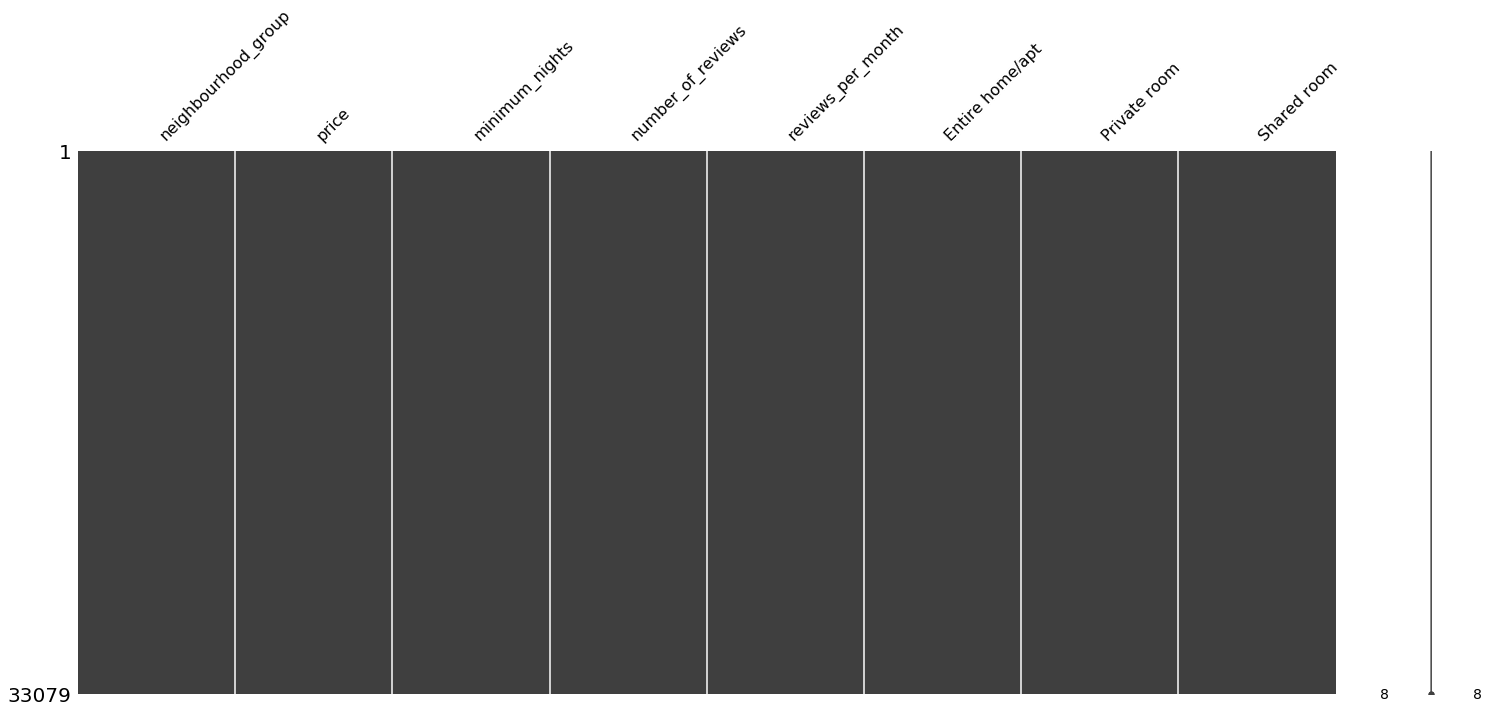

In [16]:
### 혹시 아직 결측치가 남아있는지 최종 점검

import missingno as msno
msno.matrix(final)

In [17]:
final.head()

neighbourhood_group  price  minimum_nights  number_of_reviews  \
0                    0    149               1                  9   
1                    1    225               1                 45   
3                    0     89               1                270   
4                    1     80              10                  9   
5                    1    200               3                 74   

   reviews_per_month  Entire home/apt  Private room  Shared room  
0               0.21                0             1            0  
1               0.38                1             0            0  
3               4.64                1             0            0  
4               0.10                1             0            0  
5               0.59                1             0            0

In [18]:
bk = len(final[final['neighbourhood_group']==0])
mh = len(final[final['neighbourhood_group']==1])
tt = len(final)
print("브루클린 건은 {0}건({2:.1f}%), 맨하탄 건은 {1}건({3:.1f}%)이네요.".format(bk, mh, 100*bk/tt, 100*mh/tt))

브루클린 건은 16447건(49.7%), 맨하탄 건은 16632건(50.3%)이네요.


### 본격적인 모델링 - 랜덤포레스트

In [19]:
### 랜덤 시드를 활용하여 트레인, 테스트셋 분리 / 3:1 비율로

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']], final['neighbourhood_group'], 
                                                    test_size=0.25, random_state=random_seed)

In [20]:
### 랜덤포레스트 모델 수립, 대충 하이퍼 파라미터 제공
import time
from sklearn.ensemble import RandomForestClassifier
random_seed = random.randint(0,1000)
rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=random_seed)
### 학습 진행
t0 = time.time() ## 현재시각 기록
rf.fit(X_train, y_train) 
elapsed = time.time()-t0 ## train하는데에 걸린 시간
print("걸린시간은 {:.2f}초입니다.".format(elapsed))

걸린시간은 9.04초입니다.


In [21]:
from sklearn.metrics import accuracy_score

### 학습된 모델로 분류 예측
prediction = rf.predict(X_test)
### 채점
accuracy = accuracy_score(y_test, prediction) ## X_test 가지고 학습해서 만든 predicition 가지고 y_test랑 비교해봄
### 성적 발표
print(f'Mean accuracy score: {100*accuracy:.3}%') ## 소수점 아래 셋째 자리까지 해서 나타내고, 100 곱해줌

Mean accuracy score: 60.7%


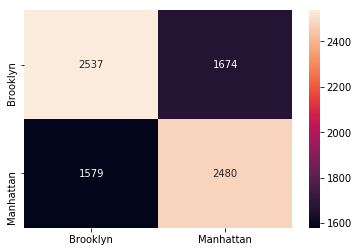

In [22]:
### 오답/정답 시각화를 위한 간단한 히트맵
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, prediction), columns=['Brooklyn', 'Manhattan'], index=['Brooklyn', 'Manhattan'])
sns.heatmap(cm, annot=True, fmt='d')

### 모델링 참고사항 - XGBOOST

In [23]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [24]:
prediction2 = clf.predict(X_test)
accuracy2 = accuracy_score(y_test, prediction2)
print('정확도 : {:.3f}%'.format(100*accuracy2))

정확도 : 64.135%


# ★퀘스트★

### 오늘 배운 모델들을 활용하여 (DT, SVM, XGBOOST / RF는 제외!!) 이보다 더 정교한 모델을 만들어보아요.
### 목표는 정확도 > 60%

(+추가)
같은 모델이더라도, 하이퍼 파라미터를 바꿔가며 코드를 실행해보면 결과가 달라집니다. 

time 모듈을 활용하여 각 모델별로 걸리는 시간도 측정해보아요.

생각보다 높은 정확도를 기록하였다면, 캐글에도 한번 등록해보아요. (https://kaggle.com)

모르는 게 있으면 질문도 좋습니다.

# GRID SEARCH 배운 김에 해봤습니다

In [66]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [58]:
#X_train
#X_test
#y_train
#y_test
dtree = DecisionTreeClassifier()
parameters = {'max_depth':[1,2,3], 'min_samples_split':[2,3]}
grid_dtree = GridSearchCV(dtree, param_grid = parameters, cv = 10, refit = True)

In [59]:
grid_dtree.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3], 'min_samples_split': [2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return

In [60]:
scores_df = pd.DataFrame(grid_dtree.cv_results_)

In [61]:
scores_df[['params', 'mean_test_score','rank_test_score','split0_test_score','split1_test_score','split2_test_score']]

params  mean_test_score  rank_test_score  \
0  {'max_depth': 1, 'min_samples_split': 2}         0.619009                1   
1  {'max_depth': 1, 'min_samples_split': 3}         0.619009                1   
2  {'max_depth': 2, 'min_samples_split': 2}         0.619009                1   
3  {'max_depth': 2, 'min_samples_split': 3}         0.619009                1   
4  {'max_depth': 3, 'min_samples_split': 2}         0.618888                5   
5  {'max_depth': 3, 'min_samples_split': 3}         0.618888                5   

   split0_test_score  split1_test_score  split2_test_score  
0           0.631749           0.622079           0.610395  
1           0.631749           0.622079           0.610395  
2           0.631749           0.622079           0.610395  
3           0.631749           0.622079           0.610395  
4           0.631749           0.622079           0.610395  
5           0.631749           0.622079           0.610395

In [62]:
print('GridSearchCV 최적 파라미터: ', grid_dtree.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dtree.best_score_))

GridSearchCV 최적 파라미터:  {'max_depth': 1, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.6190


In [63]:
estimator = grid_dtree.best_estimator_

pred = estimator.predict(X_test)
print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test,pred)))

테스트 데이터 세트 정확도: 0.6065


# 일반 DT

In [70]:
dtc = DecisionTreeClassifier()
dtc = dtc.fit(X_train, y_train)
dtc_prediction = dtc.predict(X_test)

In [87]:
dtc2 = DecisionTreeClassifier(max_depth=7, random_state=4)
dtc2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=4, splitter='best')

In [88]:
dtc2_pred_y = dtc2.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(y_test, dtc2_pred_y))

Accuracy: 0.63
